# Mitigation bias in recommender systems

This is an introduction to fairness in recommender systems. A recommender system aims to recommend the best item according to the user preference. In this tutorial, we will focus on the task of correctly predicting users' music preference.

A recommender system can be biased in multiple ways. For example, we may be concerned that the artists in our database will not get equal representation (item fairness). Alternative, our main concern may be that different groups of users (e.g. male/female users) will get different music recommendations (user fairness). In the following, we will show how to explore the data for fairness, and measure these various types of fairness using the holisticai library.

## Importing the data

We will start by importing the example dataset, which we host on our library. The [datatset](https://www.kaggle.com/datasets/ravichaubey1506/lastfm) contains a set of artists that were downloaded by users. It includes personal information about the user, specifically sex and country of origin. A user can download more than one artist. We will use the column "score", which contains only 1s for counting the interactions.

In [1]:
# sys path
import sys
sys.path.append('../../')

In [2]:
import numpy as np
import pandas as pd
import sys
sys.path.append('../')
from holisticai.datasets import load_last_fm

bunch = load_last_fm()
lastfm = bunch['frame']
lastfm['score'] = 1
lastfm

,user,artist,sex,country,score
0,1.0,red hot chili peppers,f,Germany,1
1,1.0,the black dahlia murder,f,Germany,1
2,1.0,goldfrapp,f,Germany,1
3,1.0,dropkick murphys,f,Germany,1
4,1.0,le tigre,f,Germany,1
...,...,...,...,...,...
289950,19718.0,bob dylan,f,Canada,1
289951,19718.0,pixies,f,Canada,1
289952,19718.0,the clash,f,Canada,1
289953,19718.0,a tribe called quest,f,Canada,1


We now need to change the dataframe to an interaction matrix, where every row is a user and every column is an artist. We can use the formatting function provided in the library, the output dataframe can be used as an input to the bias metric functions for recommenders.

In [3]:
# import formatters
from holisticai.utils import recommender_formatter

# Each interaction results in a non-nan entry in the dataframe.
df_pivot, p_attr = recommender_formatter(lastfm, users_col='user', groups_col='sex', items_col='artist', scores_col='score', aggfunc='mean')

In [4]:
df_pivot

artist,...and you will know us by the trail of dead,2pac,3 doors down,30 seconds to mars,311,36 crazyfists,44,50 cent,65daysofstatic,Edith piaf,...,weezer,wilco,within temptation,wolfgang amadeus mozart,wu-tang clan,yann tiersen,yeah yeah yeahs,yellowcard,yo la tengo,zero 7
user,,,,,,,,,,,,,,,,,,,,,
1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19713.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
19714.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
19715.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN


In [6]:
print ('Number of Unique Users : ' + str(df_pivot.shape[0]))
print ('Number of Unique Artists : ' + str(df_pivot.shape[1]))

Number of Unique Users : 15000
Number of Unique Artists : 1004


## Train a Model

There are many ways to recommend artists to users. We will use item based collaborative filtering since it is the simplest and most intuitive approach. For each artist, we work out a list of most similar artists. Then we recommend artists to users by looking at which artists they like, and choosing the most similar ones.

In [7]:
index_to_artist = dict(zip(range(len(df_pivot.columns)),df_pivot.columns))
artist_to_index = dict(zip(df_pivot.columns,range(len(df_pivot.columns))))
user_gender_dict = dict(zip(df_pivot.index, p_attr))

In [8]:
data_matrix = df_pivot.fillna(0).to_numpy()
time_mask = data_matrix>0

In [9]:
from holisticai.utils.models.recommender.item_selection.selectors import (
    ActiveLearningItemsSelection,
    ConventionalItemsSelection,
    RandomItemSelection
)

These all make sense to a human evaluator

In [10]:
def explode(arr, num_items):
    out = np.zeros(num_items)
    out[arr] = 1
    return out

In [12]:
from holisticai.mitigation.bias import DebiasingLearningMF,PopularityPropensityMF
from holisticai.metrics.bias import recommender_bias_metrics

mf = PopularityPropensityMF(K=40, beta=0.02, steps=100, verbose=1)
mf.fit(data_matrix)

item_selector = ConventionalItemsSelection(top_n=10)
recommended_items,_ = item_selector(time_mask=time_mask, pred_data=mf.pred)

new_recs = [explode(recommended_items[u], len(df_pivot.columns)) for u in range(df_pivot.shape[0])]
new_df_pivot_db = pd.DataFrame(new_recs, columns = df_pivot.columns)

mat = new_df_pivot_db.replace(0,np.nan).to_numpy()
recommender_bias_metrics(mat_pred=mat, metric_type='item_based')

100%|██████████| 100/100 [08:02<00:00,  4.83s/it]
d:\personal\Cristian\GitHub\HAI-PV\holisticai\tutorials\mitigating_bias_tutorials\../..\holisticai\utils\_recommender_tools.py:228: RuntimeWarning: divide by zero encountered in log
  return -np.sum(np.where(p != 0, p * np.log(p), 0))
d:\personal\Cristian\GitHub\HAI-PV\holisticai\tutorials\mitigating_bias_tutorials\../..\holisticai\utils\_recommender_tools.py:228: RuntimeWarning: invalid value encountered in multiply
  return -np.sum(np.where(p != 0, p * np.log(p), 0))


,Value,Reference
Metric,,
Aggregate Diversity,0.841633,1
GINI index,0.909744,0
Exposure Distribution Entropy,4.495381,-
Average Recommendation Popularity,4028.750013,-


In [13]:
from holisticai.mitigation.bias import DebiasingLearningMF,PopularityPropensityMF
from holisticai.metrics.bias import recommender_bias_metrics,gini_index
from holisticai.utils.models.recommender.matrix_factorization.non_negative import NonNegativeMF
from holisticai.datasets.synthetic.user_feedback import load_data
import matplotlib.pyplot as plt
from tqdm import trange
import warnings
warnings.filterwarnings("ignore")

rating_matrix , time_matrix , test_rating_matrix = load_data()
numItems,numUsers = rating_matrix.shape

item_selector = ConventionalItemsSelection(top_n=10)
strategies = {
    'NNF':NonNegativeMF(K=10),
    'DebiasingLearning':DebiasingLearningMF(K=10, normalization='Vanilla', lamda=0.004, metric='mse', bias_mode='Regularized', seed=1, verbose=1),
    'PopularityPropensity':PopularityPropensityMF(K=10, beta=0.02, steps=100, verbose=1),
}

metrics_dict = {}
for strategy_name,mf in strategies.items():
    time_mask = (time_matrix<3).copy()
    metrics = []
    for _ in trange(20):
        mf.fit(rating_matrix*time_mask)
        recommended_items , time_mask = item_selector(pred_data=mf.pred, time_mask=time_mask)
        new_recs = np.array([explode(recommended_items[u], numItems) for u in range(numUsers)])
        metrics.append(gini_index(new_recs))
    metrics_dict[strategy_name] = metrics

100%|██████████| 20/20 [08:38<00:00, 25.92s/it]


Text(0, 0.5, 'Gini Score')

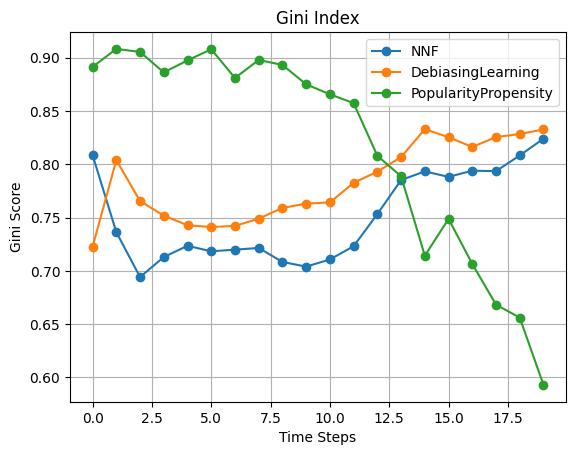

In [41]:
plt.title('Gini Index')
legend = metrics_dict.keys()
for strategy_name,curve in metrics_dict.items():
    plt.plot(curve,'-o')
plt.legend(legend)
plt.grid()
plt.xlabel('Time Steps')
plt.ylabel('Gini Score')